# Search Model

> A highly flexible model for forecasting search clicks for a given budget

In [199]:
#| default_exp model/search_volume

In [200]:
#| hide
from nbdev.showdoc import *

In [201]:
#| export
from enum import StrEnum

import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import xarray as xr

from search_forecast.wrapper.pymc_wrapper import (
    Prior, HSGP, HSGPPeriodic, YearlyFourier, WeeklyFourier,
    Data)
from search_forecast.utils.data_gen import hill

In [202]:
#| export
class ImpressionPrior(StrEnum):
    """
    Enum for prior distributions of impressions.
    """
    fraction_search_volume_available = "fraction_search_volume_available"
    competitor_pressure = "competitor_pressure"

In [ ]:
#| export
class ImpressionModel:
    """A class to represent the impression model."""
    def __init__(self, 
        dims: tuple[str],
        priors: dict[ImpressionPrior, dict[str, str|float]] | None = None,
        ):
        self.dims = dims
        if priors is None:
            priors = self._default_priors()
        
        self.priors = self._default_priors() | priors
        
        self.model = None
    
    def _process_priors(self):
        """Process the priors for the model."""
        processed_priors = {}
        for prior, params in self.priors.items():
            processed_priors[prior] = Prior(str(prior), **params)
        return processed_priors
        
    def _default_priors(self):
        """Default priors for the model."""
        return {
            ImpressionPrior.fraction_search_volume_available:  dict(prior_name="Beta", alpha=0.5, beta=0.5),
            ImpressionPrior.competitor_pressure: dict(prior_name="HalfCauchy", beta=1)
        }

    def create_model(
        self,
        search_volume: pt.TensorVariable, # Search Volume
        budget: pt.TensorVariable, # Budget
        model: pm.Model | None = None # Model Context,
        ) -> pt.TensorVariable:
        """A model to convert search volume and budget into impressions."""
        model = pm.modelcontext(model)
        self.model = model
        priors = self._process_priors()
        with model:
            multiplier = priors[ImpressionPrior.fraction_search_volume_available].apply()
            competitor_pressure= priors[ImpressionPrior.competitor_pressure].apply()

            impression_rate = pm.Deterministic("impression_rate", multiplier * hill(budget, competitor_pressure, 1.0), dims=self.dims)
            
            impressions = pm.Binomial("impressions", n=search_volume, p=impression_rate, dims=self.dims)
            return impressions

       
    def observe_impressions(
        self,
        impressions: np.ndarray, # Impressions
        coords: dict[str, np.ndarray] | None = None, # Coordinates

    ):
        """Observe the impressions in the model."""
        if self.model is None:
            raise ValueError("Model is not created yet.")
        
        self.model = pm.observe(self.model, {"impressions": impressions})
        if not coords is None:
            with self.model:
                pm.set_data({'impressions': impressions}, coords=coords)
        return self.model
    

In [191]:
## Prior for long-term periodicity
ls_long_periodic = Prior(
    'ls_lp', 
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5)
scale_long_periodic = Prior(
    'scale_lp',
    prior_name="Exponential",
    lam=1/100.0)
long_periodic = HSGPPeriodic(
    "long_term_periodic",
    m=40,
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'),
    period=365 # yearly
)

## Short-term periodicity for search volume assume similar across geo
weekly_periodic = WeeklyFourier(
    name='weekly_periodic',
    n_order=3,
    prefix='weekly_search_volume',
    dims=('date',)
    )
    

daily_geo_shocks_search_volume = Prior(
        "daily_geo_shocks_search_volume",
        prior_name="Normal", 
        mu=0, 
        sigma=Prior(
            "daily_geo_shocks_search_volume_scale", 
            prior_name="HalfCauchy", 
            beta=1
        ), 
        dims=('date', 'geo')
    )
    
base_volume = Prior(
        "base_volume",
        prior_name="Normal",
        mu=Prior(
            "base_volume_mu", 
            prior_name="Normal", 
            mu=15000, 
            sigma=1000),
        sigma=Prior(
            "base_volume_sigma",
            prior_name="HalfNormal", 
            sigma=500),
        dims=('geo',)
    )

time_data = Data('time', dims=('date'))

ls_short_periodic = Prior("ls_sp", prior_name="Gamma", alpha=1, beta=1/30)
scale_short_periodic = Prior("scale_sp", prior_name="Exponential", lam=1)

short_periodic_ctr= HSGPPeriodic(
    "short_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'),
    period=7 # weekly
)

ls_long_periodic_ctr = Prior(
    "ls_lp_ctr",
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5
    )
scale_long_periodic_ctr = Prior(
    "scale_lp_ctr", 
    prior_name="Exponential", 
    lam=1
    )
long_periodic_ctr = HSGPPeriodic(
    "long_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic_ctr,
    scale=scale_long_periodic_ctr,
    dims=('date', 'geo'),
    period=365 # yearly
)

ctr_season = (
    short_periodic_ctr 
    + long_periodic_ctr 
    + Prior("base_ctr", prior_name="Normal", mu=0, sigma=1)
)

search_volume_lam = (
    long_periodic 
    + weekly_periodic
    + base_volume
    + daily_geo_shocks_search_volume
    )(time_data)


In [192]:
imp_model = ImpressionModel(dims=('date', 'geo'))

coords = {
    "date": pd.date_range(start="2023-01-01", periods=100, freq="D"),
    "geo": ['geo_1', 'geo_2', 'geo_3'],
}
with pm.Model(coords=coords) as search_volume_model:
    search_volume = search_volume_lam.apply(np.arange(100))
    search_volume_obs = pm.Poisson("search_volume_obs", mu=pt.softplus(search_volume), dims=('date', 'geo'))
    budget = Data('budget', dims=('date', 'geo'))
    budget_data = budget.apply(np.random.gamma(1, 1, size=(100, 3)))
    impressions = imp_model.create_model(search_volume_obs, budget_data)
    
    
    #clicks = imps_to_clicks(impressions, search_volume_model['long_term_periodic'], data['time'].values[:100])

In [193]:
import matplotlib.pyplot as plt

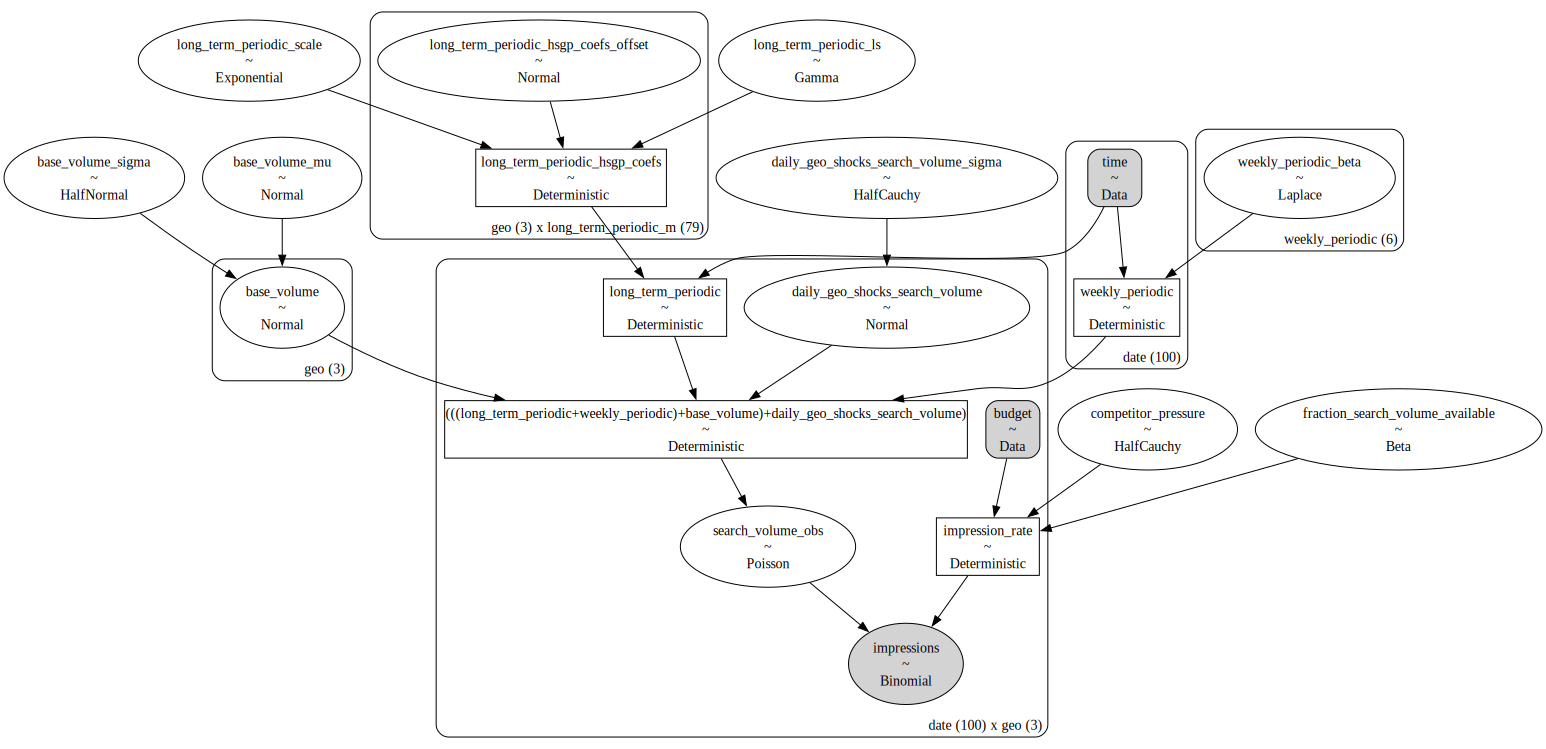

In [194]:
imp_model.observe_impressions(np.random.binomial(100, .4, size=(100, 3)))
# intervention_model = imp_model.do(
#     {"search_volume_obs": np.random.poisson(100, size=(100, 3)),
#      "budget": np.random.gamma(1, 1, size=(100, 3))},
#      prune_variables=True
# )
pm.model_to_graphviz(imp_model.model)

In [197]:
with imp_model.model:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [long_term_periodic_scale, long_term_periodic_ls, long_term_periodic_hsgp_coefs_offset, weekly_periodic_beta, base_volume_mu, base_volume_sigma, base_volume, daily_geo_shocks_search_volume_sigma, daily_geo_shocks_search_volume, fraction_search_volume_available, competitor_pressure]
>Metropolis: [search_volume_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [196]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

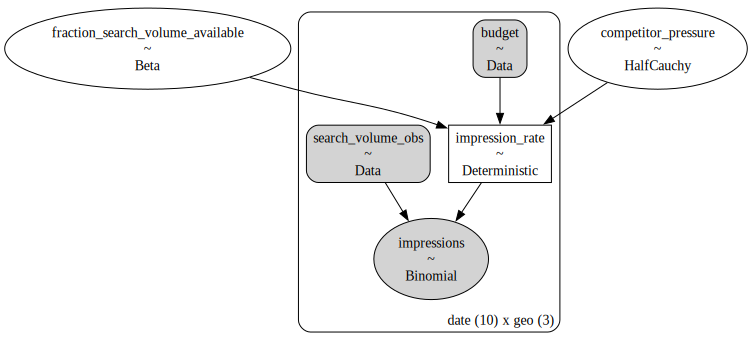

In [189]:
pm.model_to_graphviz(
    imp_model.posterior(
        trace, 
        interventions={
            "search_volume_obs": np.random.poisson(100, size=(10, 3)), 
            'budget': np.random.lognormal(1, .3, size=(10,3))
        }, 
        coords={
            'date': pd.date_range(start="2023-01-01", periods=10, freq="D")
        }
    )
)


In [100]:
with pm.do(pm.observe(search_volume_model, {"impressions": np.random.binomial(100, .4, size=(100, 3))}), {"budget": np.random.gamma(1, 1, size=(100, 3)), "search_volume_obs":np.random.poisson(100, size=(100, 3))}, prune_vars=True) as model:
    ...

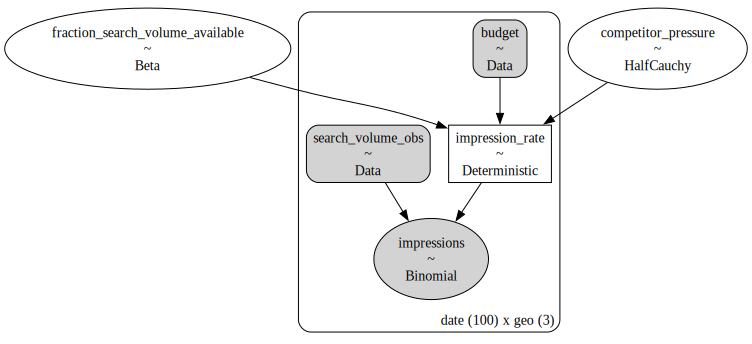

In [102]:
pm.model_to_graphviz(model)